In [1]:
import pandas as pd
# import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 

In [2]:
%load_ext rpy2.ipython

In [3]:
import seaborn as sns
print(sns.__version__)  # 输出应为 0.11.0 或更高

0.13.0


In [4]:
import pybedtools
from pybedtools import BedTool
def inter(df, r_df):
    """pro, frag intersect"""
    
    dfbed = BedTool.from_dataframe(df)
    rbed = BedTool.from_dataframe(r_df)
    intersect = dfbed.intersect(rbed, wa=True, wb=True)
    # intersect2 = intersect.intersect(fbed, wa=True, wb=True, loj=True)

    colnames = [
        "chr", "start", "end",
        "chrom", "r_start", "r_end", "read_id", "strand", "fragment", "acc", "Msegment"
        ]
    int_df = intersect.to_dataframe(names=colnames)

    pybedtools.cleanup() 
    
    return int_df

In [5]:
sns.set(style='white')  # 图形主题
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [ ]:
# 读取 GpC 甲基化片段信息
GM_GpC_df = pd.read_table("~/map_frag_methylation.bed", header=None)
GM_GpC_df.columns = ['chrom', 'start', 'end', 'read_id', 'strand', 'fragment', 'acc', 'Msegment']

# 读取 CpG 甲基化片段信息，
GM_CpG_df = pd.read_table("~/map_frag_CpG_methylation_segments.bed", header=None)
GM_CpG_df = GM_CpG_df.loc[GM_CpG_df[8].isna()]  # 过滤
GM_CpG_df = GM_CpG_df[[0,1,2,3,4,5,6,7]]  # 只保留前8列
GM_CpG_df.columns = ['chrom', 'start', 'end', 'read_id', 'strand', 'fragment', 'Msegment', 'UnMsegment']

# 读取区域信息表格 
PIVOT_DF = pd.read_table("~/PIVOT_DF.txt")

# 筛选 chr2 染色体的区域
PIVOT_DF = PIVOT_DF.loc[PIVOT_DF['chr']=='chr2']

# 筛选 chr2 特定坐标范围（27M-27.5M）区域
washu_region = PIVOT_DF.loc[(PIVOT_DF['start']>=27000000) & (PIVOT_DF['end']<=27500000)]

# 提取不同基因对应的区域，并只保留基本坐标信息
select_High_region = washu_region.loc[washu_region['gene']=='PPM1G'][['chr', 'start', 'end']].copy()
select_Mid_region = washu_region.loc[washu_region['gene']=='AGBL5'][['chr', 'start', 'end']].copy()
select_Low_region = washu_region.loc[washu_region['gene']=='EMILIN1'][['chr', 'start', 'end']].copy()
select_None_region = washu_region.loc[washu_region['gene']=='TCF23'][['chr', 'start', 'end']].copy()

# 筛选 GpC 数据
select_GpC_washuregion = GM_GpC_df.loc[GM_GpC_df['chrom']=='chr2'].copy()
select_GpC_washuregion = select_GpC_washuregion.loc[
    (select_GpC_washuregion['start']>=27000000) & (select_GpC_washuregion['end']<=27500000)]

# 交集提取：找出与不同区域重叠的 GpC read_id
High_interGC_list = inter(select_High_region, select_GpC_washuregion)['read_id'].tolist()
Mid_interGC_list = inter(select_Mid_region, select_GpC_washuregion)['read_id'].tolist()
Low_interGC_list = inter(select_Low_region, select_GpC_washuregion)['read_id'].tolist()
None_interGC_list = inter(select_None_region, select_GpC_washuregion)['read_id'].tolist()

# 找出与不同区域重叠的 CpG read_id
High_interCG_list = inter(select_High_region, select_CpG_washuregion)['read_id'].tolist()
Mid_interCG_list = inter(select_Mid_region, select_CpG_washuregion)['read_id'].tolist()
Low_interCG_list = inter(select_Low_region, select_CpG_washuregion)['read_id'].tolist()
None_interCG_list = inter(select_None_region, select_CpG_washuregion)['read_id'].tolist()

# 找到同时与 GpC 和 CpG 区域重叠的 read_id
overlap_High_id = list(set(High_interGC_list).intersection(set(High_interCG_list)))
overlap_Mid_id = list(set(Mid_interGC_list).intersection(set(Mid_interCG_list)))
overlap_Low_id = list(set(Low_interGC_list).intersection(set(Low_interCG_list)))
overlap_None_id = list(set(None_interGC_list).intersection(set(None_interCG_list)))

# 构建 GpC 区域重叠的读取信息字典，按 read_id 最小 start 排序
GC_washU_selectid_dict = {}
for i in [[overlap_High_id, 'High'], [overlap_Mid_id, 'Mid'], [overlap_Low_id, 'Low'], [overlap_None_id, 'None']]:
    tmp_df = select_GpC_washuregion.loc[select_GpC_washuregion['read_id'].isin(i[0])]
    tmp_group = tmp_df.groupby(tmp_df.read_id)
    tmp_dict = {}
    for readID, gdf in tmp_group:
        tmp_dict[readID] = gdf.reset_index(drop=True)
    tmp_sort_dict = {readid: min(frame["start"]) for readid, frame in tmp_dict.items()}
    tmp_sort_list = sorted(tmp_sort_dict.items(), key=lambda kv: (kv[1], kv[0]))

    GC_washU_selectid_dict[i[1]] = [tmp_df, tmp_sort_list]

# 构建 CpG 区域重叠的读取信息字典，同样按 read_id 的 start 排序
CG_washU_selectid_dict = {}
for i in [[overlap_High_id, 'High'], [overlap_Mid_id, 'Mid'], [overlap_Low_id, 'Low'], [overlap_None_id, 'None']]:
    tmp_df = select_CpG_washuregion.loc[select_CpG_washuregion['read_id'].isin(i[0])]
    tmp_group = tmp_df.groupby(tmp_df.read_id)
    tmp_dict = {}
    for readID, gdf in tmp_group:
        tmp_dict[readID] = gdf.reset_index(drop=True)
    tmp_sort_dict = {readid: min(frame["start"]) for readid, frame in tmp_dict.items()}
    tmp_sort_list = sorted(tmp_sort_dict.items(), key=lambda kv: (kv[1], kv[0]))

    CG_washU_selectid_dict[i[1]] = [tmp_df, tmp_sort_list]

# 准备输出数据：High 区域的 GpC 数据，加上 mapq 字段，重新整理列顺序
out1 = GC_washU_selectid_dict['High'][0].copy()
out1['mapq'] = 30
out1 = out1[['chrom', 'start', 'end', 'read_id', 'mapq', 'strand', 'fragment']]

# 同样处理 Low 区域的 GpC 数据
out2 = GC_washU_selectid_dict['Low'][0].copy()
out2['mapq'] = 30
out2 = out2[['chrom', 'start', 'end', 'read_id', 'mapq', 'strand', 'fragment']]

# 为输出文件加上 tag 
out1['tag'] = range(len(out1))
out1['fragment'] = 1 
out2['tag'] = range(len(out2))
out2['fragment'] = 1
out2['strand'] = "+"  


In [ ]:
# 设置子图之间的纵向间距
plt.subplots_adjust(hspace=0.1)

# 创建一个 1x1 的图像网格（只有一个子图），x轴共享
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True)

# 设置整个图像的尺寸为 8英寸宽、2英寸高
fig.figure.set_size_inches(8, 2)

# 遍历 GC_washU_selectid_dict['High'] 中的所有排序后的 read_id 列表
for i in GC_washU_selectid_dict['High'][1]:
    # 选取当前 read_id 对应的所有片段（即属于同一条测序 read 的所有片段）
    row1 = GC_washU_selectid_dict['High'][0].loc[GC_washU_selectid_dict['High'][0].read_id == i[0]]
    
    # 遍历该 read 中的每一行片段（即每个片段位置）
    for index, row in row1.iterrows():
        # 绘制每个片段的范围，用灰色线段表示整个 GpC 片段
        axes.plot([row["start"], row["end"]], [row["read_id"], row["read_id"]], '-', color="dimgray", linewidth=0.8, alpha=0.5)

        # 如果该片段中存在甲基化信息（Msegment不为 '0'）
        if row['Msegment'] != '0':
            # Msegment 中存储的多个甲基化区域用逗号分隔
            for i in row['Msegment'].split(','):
                fstart = int(i.split('-')[0])  # 起始位置
                fend = int(i.split('-')[1])    # 终止位置
                # 用红色线段绘制甲基化区域
                axes.plot([fstart, fend], [row["read_id"], row["read_id"]], '-', color="#E64B35", linewidth=0.8)

# 去除 y 轴刻度和标签（只保留 x 轴）
axes.tick_params(labelleft=False, left=False, bottom=True)

# 设置 y 轴标签，标明 read 数量和对应的基因（如 PPM1G）
axes.set_ylabel(f"N = {len(GC_washU_selectid_dict['High'][1])}\nPPM1G")

# 设置 x 轴范围，对应所分析的染色体区间
plt.xlim(27000000, 27500000)

# 自动调整布局，使得图像组件不会重叠
plt.tight_layout()

In [ ]:
def py_trans_r_format(transid_list, trans_df):
    n = 0
    out_df = pd.DataFrame()
    for i in transid_list:
        # print(i)
        tmp_all = trans_df.loc[trans_df['read_id']==i].copy()
        tmp_base = tmp_all[['start', 'end']].copy()
        tmp_base.columns = ['xmin', 'xmax']
        tmp_base['ymin'] = n
        tmp_base['ymax'] = n + 1
        tmp_base['color'] = '#e7e6e5'
        # print(tmp_all)
        
        tmp_df_list = []
        tmp_acc_start_list = []
        tmp_acc_end_list = []
        tmp_ymin = []
        tmp_ymax = []
        tmp_color = []
        if len(tmp_all.loc[tmp_all['Msegment']!='0']) !=0:
            tmp_acc = tmp_all.loc[tmp_all['Msegment']!='0']
            for tmp_index, tmp_row in tmp_acc.iterrows():
                for tmp_acc_region in tmp_row['Msegment'].split(','):
                    tmp_acc_start = int(tmp_acc_region.split('-')[0])
                    tmp_acc_end = int(tmp_acc_region.split('-')[1])
                    tmp_acc_start_list.append(tmp_acc_start)
                    tmp_acc_end_list.append(tmp_acc_end)
                    tmp_ymin.append(n)
                    tmp_ymax.append(n+1)
                    tmp_color.append("#E64B35")
        tmp_df_list.append(tmp_acc_start_list)
        tmp_df_list.append(tmp_acc_end_list)
        tmp_df_list.append(tmp_ymin)
        tmp_df_list.append(tmp_ymax)
        tmp_df_list.append(tmp_color)
        tmp_df = pd.DataFrame(tmp_df_list).T
        tmp_df.columns=['xmin', 'xmax', 'ymin', 'ymax', 'color']
    
        tmp_concat_df = pd.concat([tmp_base, tmp_df])
        out_df = pd.concat([out_df, tmp_concat_df])
        data_types = {'xmin': 'int',
                  'xmax': 'int',
                  'ymin': 'int',
                  'ymax': 'int'}
        out_df = out_df.astype(data_types)
        n += 1
    return out_df
    

In [ ]:
def py_transCG_r_format(transid_list, trans_df):
    """
    将数据格式化为绘图输入格式，包含背景块、高甲基化块、低甲基化块。
    """
    n = 0  # 用于控制 y 坐标层数
    out_df = pd.DataFrame()  # 存储最终结果

    for trans_id in transid_list:
        # 获取当前 read 的全部片段
        read_df = trans_df[trans_df['read_id'] == trans_id].copy()

        # 创建背景灰色块（原始片段）
        base_df = read_df[['start', 'end']].copy()
        base_df.columns = ['xmin', 'xmax']
        base_df['ymin'] = n
        base_df['ymax'] = n + 1
        base_df['color'] = '#e7e6e5'  # 灰色表示原始区域

        segment_data = []  # 用于收集高低甲基化区域

        # 处理高甲基化区域（Msegment）
        high_m_df = read_df[read_df['Msegment'] != '0']
        for _, row in high_m_df.iterrows():
            for region in row['Msegment'].split(','):
                start, end = map(int, region.split('-'))
                segment_data.append({
                    'xmin': start,
                    'xmax': end,
                    'ymin': n,
                    'ymax': n + 1,
                    'color': '#f29b80'  # 浅红色
                })

        # 处理低甲基化区域（UnMsegment）
        low_m_df = read_df[read_df['UnMsegment'] != '0']
        for _, row in low_m_df.iterrows():
            for region in row['UnMsegment'].split(','):
                start, end = map(int, region.split('-'))
                segment_data.append({
                    'xmin': start,
                    'xmax': end,
                    'ymin': n,
                    'ymax': n + 1,
                    'color': '#50bad5'  # 蓝色
                })

        # 构造高低甲基化数据的 DataFrame
        segment_df = pd.DataFrame(segment_data)

        # 合并背景片段和甲基化片段
        combined_df = pd.concat([base_df, segment_df], ignore_index=True)
        out_df = pd.concat([out_df, combined_df], ignore_index=True)

        n += 1  # 下一条 read 的 y 坐标往上移一层

    # 保证数值字段为整数类型
    out_df = out_df.astype({'xmin': int, 'xmax': int, 'ymin': int, 'ymax': int})
    return out_df
def freq_count(gene_fragment_df):
    """
    计算 gene_fragment 中 'acc' == True 的比例（频率）

    参数:
        gene_fragment_df (pd.DataFrame): 包含 'acc' 布尔字段的 DataFrame

    返回:
        float: acc == True 的频率值，范围 [0,1]
    """
    total = len(gene_fragment_df)  # 所有片段总数
    accepted = gene_fragment_df['acc'].sum()  # acc=True 的片段数
    frequency = accepted / total if total > 0 else 0  # 避免除以 0
    return frequency

In [ ]:
# 计算与当前选定基因区域的交集片段
GC_High_gene_fragment = inter(select_High_region, select_GpC_washuregion)
# 进一步筛选出只保留在已选中 High read_id 列表中的片段
GC_High_gene_fragment = GC_High_gene_fragment.loc[
    GC_High_gene_fragment['read_id'].isin(GC_washU_selectid_dict['High'][0]['read_id'].tolist())
]

# 同上，处理 Mid 表达水平的区域
GC_Mid_gene_fragment = inter(select_Mid_region, select_GpC_washuregion)
GC_Mid_gene_fragment = GC_Mid_gene_fragment.loc[
    GC_Mid_gene_fragment['read_id'].isin(GC_washU_selectid_dict['Mid'][0]['read_id'].tolist())
]

# 同上，处理 Low 表达水平的区域
GC_Low_gene_fragment = inter(select_Low_region, select_GpC_washuregion)
GC_Low_gene_fragment = GC_Low_gene_fragment.loc[
    GC_Low_gene_fragment['read_id'].isin(GC_washU_selectid_dict['Low'][0]['read_id'].tolist())
]

# 同上，处理 None（无表达）区域
GC_None_gene_fragment = inter(select_None_region, select_GpC_washuregion)
GC_None_gene_fragment = GC_None_gene_fragment.loc[
    GC_None_gene_fragment['read_id'].isin(GC_washU_selectid_dict['None'][0]['read_id'].tolist())
]

# 针对 GpC/CpG 区域绘图准备：生成 R 格式的绘图输入数据
High_GCrdata = py_trans_r_format(overlap_High_id, GC_washU_selectid_dict['High'][0]).reset_index(drop=True)
Mid_GCrdata  = py_trans_r_format(overlap_Mid_id,  GC_washU_selectid_dict['Mid'][0]).reset_index(drop=True)
Low_GCrdata  = py_trans_r_format(overlap_Low_id,  GC_washU_selectid_dict['Low'][0]).reset_index(drop=True)
None_GCrdata = py_trans_r_format(overlap_None_id, GC_washU_selectid_dict['None'][0]).reset_index(drop=True)

High_CGrdata = py_transCG_r_format(overlap_High_id, CG_washU_selectid_dict['High'][0]).reset_index(drop=True)
Mid_CGrdata = py_transCG_r_format(overlap_Mid_id, CG_washU_selectid_dict['Mid'][0]).reset_index(drop=True)
Low_CGrdata = py_transCG_r_format(overlap_Low_id, CG_washU_selectid_dict['Low'][0]).reset_index(drop=True)
None_CGrdata = py_transCG_r_format(overlap_None_id, CG_washU_selectid_dict['None'][0]).reset_index(drop=True)

In [ ]:
%%R -i High_GCrdata
head(High_GCrdata)

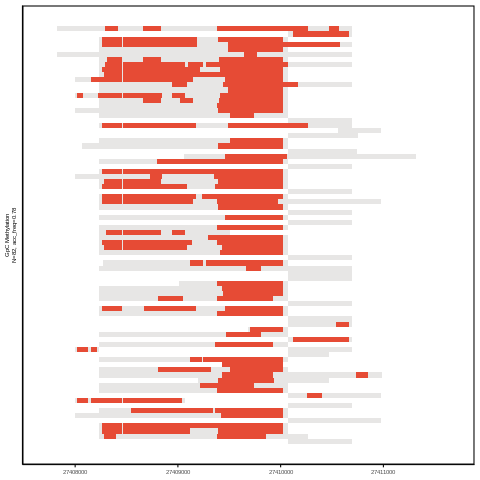

In [105]:
%%R
# 加载绘图所需的 ggplot2 包
library(ggplot2)

# 从 Python 中传入的 High_GCrdata 中提取绘图所需的矩形坐标和颜色信息
xmin <- High_GCrdata$xmin   # 矩形左边界（甲基化区段起点）
xmax <- High_GCrdata$xmax   # 矩形右边界（甲基化区段终点）
ymin <- High_GCrdata$ymin   # 矩形下边界（对应 read_id 的位置）
ymax <- High_GCrdata$ymax   # 矩形上边界
color <- High_GCrdata$color # 每个片段的颜色（灰色代表未甲基化，红色代表甲基化）

# 将所有矩形坐标整理为一个数据框，用于 ggplot 绘图
all_rectangles <- data.frame(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax)

# 创建一个 ggplot 图层对象
p <- ggplot() +
  # 添加矩形元素，每个矩形表示一个测序片段的 GpC 区域
  geom_rect(data = all_rectangles, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
            color = "white", fill = color, size = 0) +  # 使用指定颜色填充矩形，不加边框线

  # 告诉 ggplot 不需要额外映射颜色（颜色直接从 color 列中获取）
  scale_fill_identity() +

  # 设置 x 轴范围为目标基因所在区域（单位为碱基对）
  scale_x_continuous(limits = c(27407687, 27411687)) +

  # 设置 y 轴标签，展示 methylation 的信息，如 read 数量及平均甲基化频率
  labs(y = 'GpC Methylation\nN=82, acc_freq=0.78') +

  # 调整图形的样式和外观
  theme(
    panel.grid.major = element_blank(),        # 移除主网格线
    panel.grid.minor = element_blank(),        # 移除次网格线
    axis.ticks = element_line(color = "black"),# 设置坐标轴刻度线为黑色
    axis.text.y = element_blank(),             # 移除 y 轴的刻度标签
    axis.text.x = element_text(size = 6),      # 设置 x 轴文字大小
    axis.title.y = element_text(size = 6),     # 设置 y 轴标题文字大小
    axis.ticks.y = element_blank(),            # 去掉 y 轴刻度线
    panel.background = element_blank(),        # 设置背景为透明
    panel.border = element_rect(colour = "black", fill = NA, size = 1), # 添加黑色边框
    axis.line = element_line(),                # 显示坐标轴线
    plot.title = element_text(hjust = 0.5)     # 居中显示标题
  )

# 输出绘图结果
p